In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
andriitrelin_cells_raman_spectra_path = kagglehub.dataset_download('andriitrelin/cells-raman-spectra')

print('Data source import complete.')


100%|██████████| 68.5M/68.5M [00:00<00:00, 75.9MB/s]

Extracting files...


Data source import complete.


# 1. Package import and function definitions

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import glob
import os
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, classification_report

In [ ]:
# prompt: unzip the file in the directory archive_raman

import zipfile

with zipfile.ZipFile('archive_raman.zip', 'r') as zip_ref:
    zip_ref.extractall('archive_raman')

print(os.listdir('archive_raman'))


['ZAM-S', 'HF', 'G-S', 'A', 'HF-S', 'A-S', 'MEL-S', 'README.txt', 'DMEM-S', 'G', 'DMEM', 'MEL', 'dataset_i', 'ZAM']


The next hidden code cells define functions for plotting data. Click on the "Code" button in the published kernel to reveal the hidden code.

In [ ]:
def norm_func(x, a=0, b=1):
    return ((b - a) * (x - min(x))) / (max(x) - min(x)) + a

def normalize(x, y=None):
    x = np.apply_along_axis(norm_func, axis=1, arr=x)
    return x


data={}
for file in glob.glob("archive_raman/**/*.csv"):
    path = file.split(os.path.sep)
    label = path[-2]
    kind = path[-1][:-4]
    if label not in data.keys():
        data[label] = {}
    data[label][kind] = normalize(pd.read_csv(file).values)

import matplotlib.cm as cm
import umap
def plot_pca(counts,condition):

    #Define name of samples and conditions from design file


    condition=condition

    # Sample annotations (replace this with your annotations list)

    annotations = condition

    data = counts.values


    # Perform PCA
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(data)

    # Plot PCA results
    plt.figure(figsize=(8, 6))

    # Get unique annotations
    unique_annotations = set(annotations)

    # Create a colormap
    cmap = cm.get_cmap('tab20')  # You can use any other colormap you prefer


    # Plot each annotation with a different color from the colormap
    for i, annotation in enumerate(unique_annotations):
        indices = [j for j, x in enumerate(annotations) if x == annotation]
        plt.scatter(pca_result[indices, 0], pca_result[indices, 1], c=[cmap(i)], label=annotation)

    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('PCA Plot with Annotations')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_tsne(counts,condition):

    #Define name of samples and conditions from design file

    # Sample annotations (replace this with your annotations list)

    annotations = condition

    data = counts.values

    # Initialize and fit t-SNE model
    tsne = TSNE(n_components=2, random_state=42)
    tsne_result = tsne.fit_transform(data)

    # Plot t-SNE embeddings with annotations
    plt.figure(figsize=(8, 6))

    # Get unique annotations
    unique_annotations = set(annotations)

    # Create a colormap
    cmap = cm.get_cmap('tab20')  # You can use any other colormap you prefer


    # Plot each annotation with a different color from the colormap
    for i, annotation in enumerate(unique_annotations):
        indices = [j for j, x in enumerate(annotations) if x == annotation]
        plt.scatter(tsne_result[indices, 0], tsne_result[indices, 1], c=[cmap(i)], label=annotation)

    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.title('t-SNE Plot with Annotations')
    plt.legend()
    plt.grid(True)
    plt.savefig('t_SNE_tumors.png')
    plt.show()

def plot_umap(counts,condition):

    #Define name of samples and conditions from design file


    # Sample annotations (replace this with your annotations list)

    annotations = condition

    data = counts.values

    # Initialize and fit UMAP model
    umap_model = umap.UMAP(n_components=2, random_state=42)
    umap_result = umap_model.fit_transform(data)

    # Plot UMAP embeddings with annotations
    plt.figure(figsize=(8, 6))

    # Get unique annotations
    unique_annotations = list(set(annotations))

    # Create a colormap
    cmap = cm.get_cmap('tab20')  # You can use any other colormap you prefer


    # Plot each annotation with a different color from the colormap
    for i, annotation in enumerate(unique_annotations):
        indices = [j for j, x in enumerate(annotations) if x == annotation]
        plt.scatter(umap_result[indices, 0], umap_result[indices, 1], c=[cmap(i)], label=annotation)

    plt.xlabel('UMAP Component 1')
    plt.ylabel('UMAP Component 2')
    plt.title('UMAP Plot with Annotations')
    plt.legend()
    plt.grid(True)
    plt.show()

# 2. Data exploration and preprocessing

dict_keys(['ZAM-S', 'HF', 'G-S', 'A', 'HF-S', 'A-S', 'MEL-S', 'DMEM-S', 'G', 'DMEM', 'MEL', 'ZAM'])


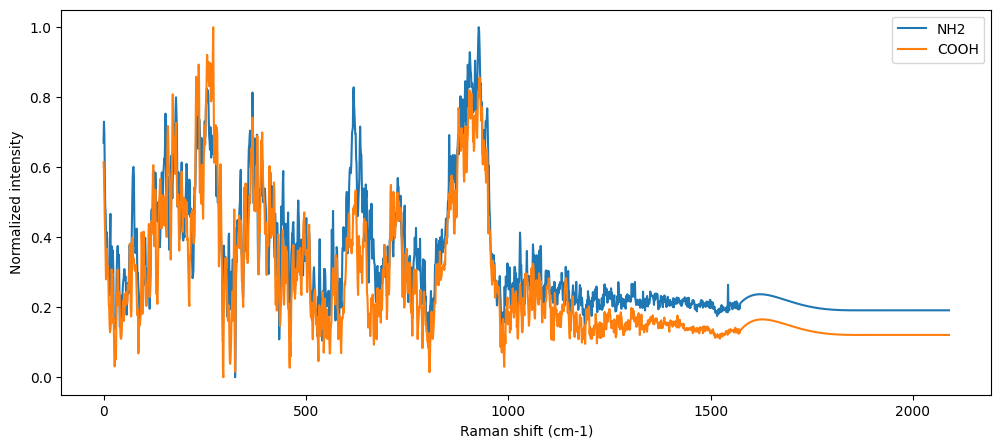

In [ ]:
print(data.keys())
plt.figure(figsize=(12,5))
plt.plot(data['HF']['NH2'][20])
plt.plot(data['HF']['COOH'][20])
plt.xlabel('Raman shift (cm-1)')
plt.ylabel('Normalized intensity')
plt.legend(['NH2','COOH'])
plt.show()

The Raman spectra from this paper look pretty noisy, still we can see if we can interpret them using PCA or T-SNE to group cell phenotypes.

In [ ]:
df_COOH=pd.DataFrame()
df_NH2=pd.DataFrame()
df_COOH2=pd.DataFrame()

condition=[]
l=0
for i in data:
    for j in data[i]:
        if j=='NH2':
            for k in data[i][j]:
                condition.append(i)
                df_NH2[l]=k
                l=l+1
condition=[]
for i in data:
    for j in data[i]:
        if j=='COOH':
            for k in data[i][j]:
                condition.append(i)
                df_COOH[l]=k
                l=l+1
condition=[]
for i in data:
    for j in data[i]:
        if j=='(COOH)2':
            for k in data[i][j]:
                condition.append(i)
                df_COOH2[l]=k
                l=l+1

<ipython-input-15-2dd0a9782eaa>:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_NH2[l]=k
<ipython-input-15-2dd0a9782eaa>:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_NH2[l]=k
<ipython-input-15-2dd0a9782eaa>:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_NH2[l]=k
<ipython-input-15-2

In [ ]:
condition=[]
df=pd.DataFrame()
for i in data:
    len_sample=[]
    for j in data[i]:
        len_sample.append(len(data[i][j]))
    for l in range(0,min(len_sample)):
        column_df=[]
        for j in data[i]:
            column_df=column_df+data[i][j][l].tolist()
        condition.insert(0,i)
        df.insert(0,i+str(l),column_df)

<ipython-input-16-fa112a0af7c1>:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.insert(0,i+str(l),column_df)
<ipython-input-16-fa112a0af7c1>:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.insert(0,i+str(l),column_df)
<ipython-input-16-fa112a0af7c1>:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.c

In [ ]:
condition=[]
df_NH2_COOH=pd.DataFrame()
for i in data:
    len_sample=[]
    for j in data[i]:
        len_sample.append(len(data[i][j]))
    for l in range(0,min(len_sample)):
        column_df=[]

        for j in data[i]:
            if j=='COOH':

                column_df=column_df+data[i][j][l].tolist()


            elif j=='NH2':
                column_df=column_df+data[i][j][l].tolist()
        condition.insert(0,i)
        df_NH2_COOH.insert(0,i+str(l),column_df)

<ipython-input-17-f8e8baf97006>:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_NH2_COOH.insert(0,i+str(l),column_df)
<ipython-input-17-f8e8baf97006>:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_NH2_COOH.insert(0,i+str(l),column_df)
<ipython-input-17-f8e8baf97006>:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `

In [ ]:
condition=[]
df_NH2_COOH2=pd.DataFrame()
for i in data:
    len_sample=[]
    for j in data[i]:
        len_sample.append(len(data[i][j]))
    for l in range(0,min(len_sample)):
        column_df=[]

        for j in data[i]:
            if j=='(COOH)2':

                column_df=column_df+data[i][j][l].tolist()


            elif j=='NH2':
                column_df=column_df+data[i][j][l].tolist()
        condition.insert(0,i)
        df_NH2_COOH2.insert(0,i+str(l),column_df)

<ipython-input-18-4f0f5a8a92df>:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_NH2_COOH2.insert(0,i+str(l),column_df)
<ipython-input-18-4f0f5a8a92df>:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_NH2_COOH2.insert(0,i+str(l),column_df)
<ipython-input-18-4f0f5a8a92df>:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use

In [ ]:
condition=[]
df_COOH_COOH2=pd.DataFrame()
for i in data:
    len_sample=[]
    for j in data[i]:
        len_sample.append(len(data[i][j]))
    for l in range(0,min(len_sample)):
        column_df=[]

        for j in data[i]:
            if j=='COOH':

                column_df=column_df+data[i][j][l].tolist()


            elif j=='(COOH)2':
                column_df=column_df+data[i][j][l].tolist()
        condition.insert(0,i)
        df_COOH_COOH2.insert(0,i+str(l),column_df)

<ipython-input-19-d4f995bbbdfe>:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_COOH_COOH2.insert(0,i+str(l),column_df)
<ipython-input-19-d4f995bbbdfe>:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_COOH_COOH2.insert(0,i+str(l),column_df)
<ipython-input-19-d4f995bbbdfe>:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, u

# 3. Dimensionnality reduction

<ipython-input-10-9dbd1d47628c>:45: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20')  # You can use any other colormap you prefer


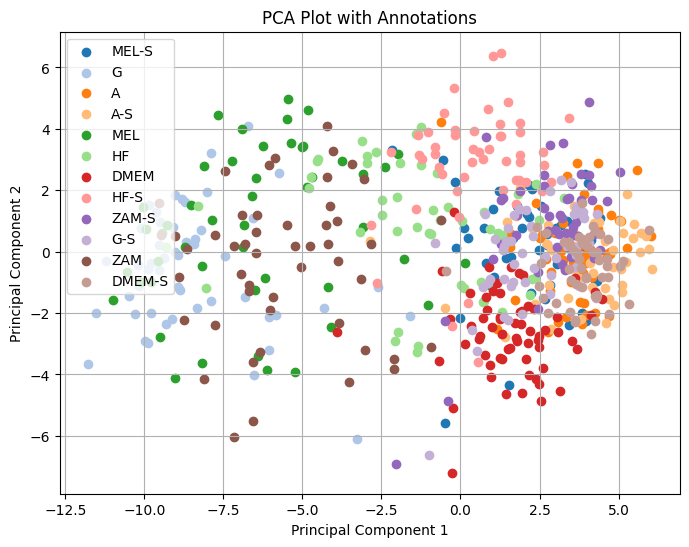

In [ ]:
plot_pca(df.transpose(),condition)

As we can see from the plot of the 2 first PC, there seems to be some grouping corresponding to the different phenotypes however it isn't that clear here.

<ipython-input-10-9dbd1d47628c>:45: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20')  # You can use any other colormap you prefer


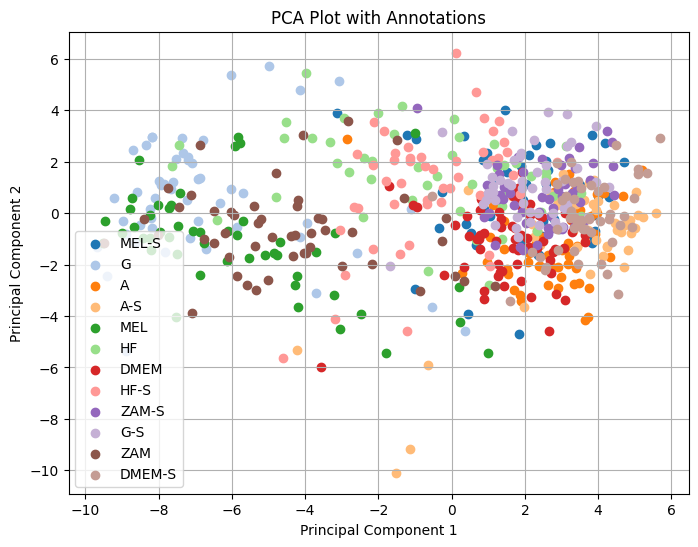

In [ ]:
plot_pca(df_NH2_COOH.transpose(),condition)

<ipython-input-10-9dbd1d47628c>:81: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20')  # You can use any other colormap you prefer


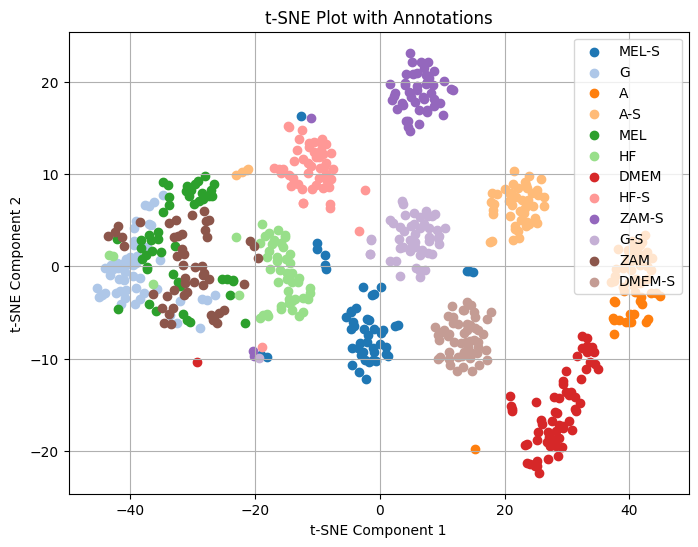

In [ ]:
plot_tsne(df.transpose(),condition)

Using T-SNE grouping of the spectra from the different cells, becomes very clear.

<ipython-input-10-9dbd1d47628c>:81: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20')  # You can use any other colormap you prefer


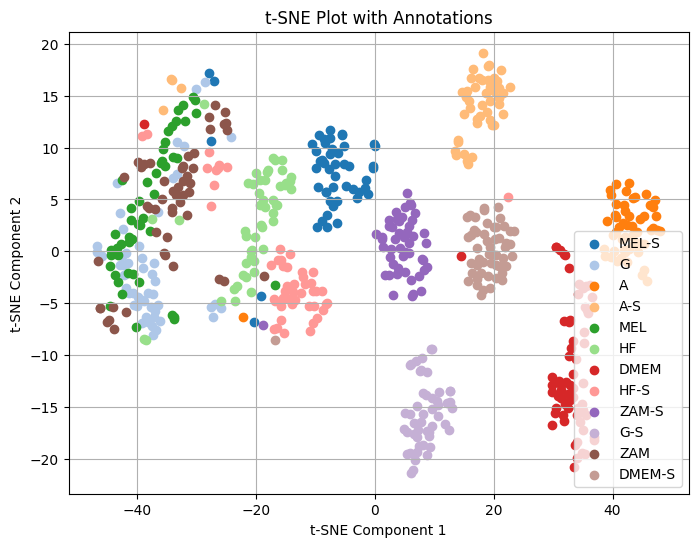

In [ ]:
plot_tsne(df_NH2_COOH.transpose(),condition)

In [ ]:
plot_tsne(df_NH2_COOH.transpose(),condition)

Using T-SNE grouping of the spectra from the different cells, becomes very clear even using only data from NPs functionnalized with NH2_COOH only.

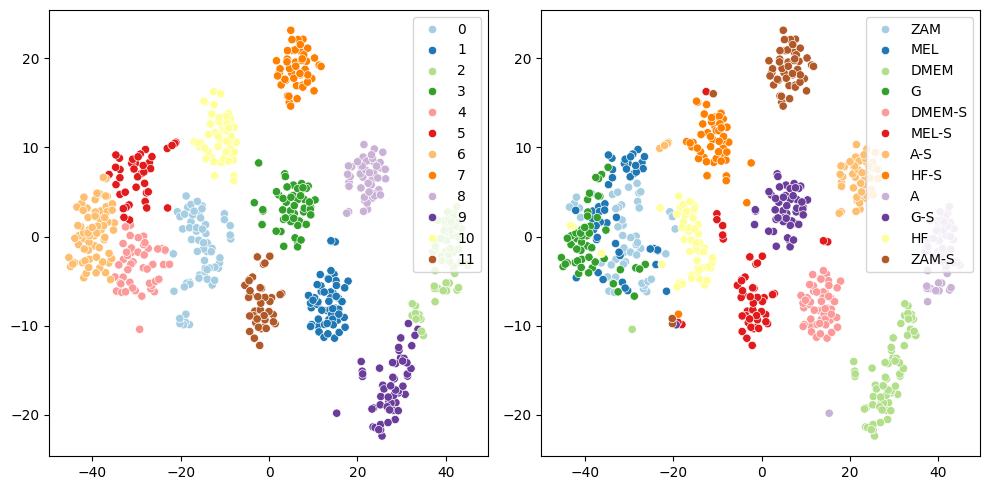

In [ ]:
#Here we use again T-SNE and use K-means as clustering method to predict cluster from the T-SNE grouping

from sklearn.cluster import KMeans
import seaborn as sns


tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(df.transpose())

KM=KMeans(n_clusters=12)

KM.fit(tsne_result)

fig,axs=plt.subplots(1,2,figsize=(10,5))
sns.color_palette("Paired")
# Pass x and y data using keyword arguments
sns.scatterplot(x=tsne_result[:,0], y=tsne_result[:,1], hue=KM.labels_, palette='Paired', ax=axs[0])
sns.scatterplot(x=tsne_result[:,0], y=tsne_result[:,1], hue=condition, palette='Paired', ax=axs[1])
fig.tight_layout()

On the left we can see T-SNE projection from the different SERS spectra with labels predicted from KMeans, and on the rights with labels coming from the dataset. As can be seen, Kmeans seems to be doing a pretty good job at predicting the clusters. On the next slide we'll use a confusion matrix to illustrate the performance of KMeans to predict the rights classes.

# 4. Metrics plotting

In [ ]:
list=KM.labels_

list=[6 if x == 0 else 0 if x == 6 else x for x in list]
list=[3 if x == 2 else 2 if x == 3 else x for x in list]
list=[8 if x == 3 else 3 if x == 8 else x for x in list]
list=[10 if x == 4 else 4 if x == 10 else x for x in list]
list=[7 if x == 6 else 6 if x == 7 else x for x in list]
list=[9 if x == 8 else 8 if x == 9 else x for x in list]
list=[11 if x == 9 else 9 if x == 11 else x for x in list]
list=[11 if x == 10 else 10 if x == 11 else x for x in list]

<Axes: >

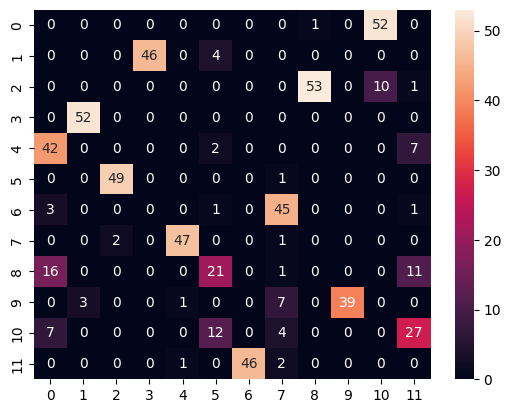

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix

le=LabelEncoder()

true_label=le.fit_transform(condition)


conf_mat=confusion_matrix(true_label,list)

sns.heatmap(conf_mat,annot=True)

# 5. Conclusions


From the confusion matrix, we can see the diagonal has the most predictions which mean the predict clusters are pretty similar to true clusters ! Still more preprocessing steps could help getting better results, such as baseline removal and background susbtration. At the same time some other algorithms such as deep learning algorithms could be used to improve the predictions.

Best Parameters for NH2: {'kernel': 'rbf', 'gamma': np.float64(0.31622776601683794), 'C': np.float64(10.0)}
SVM Classification Report for NH2:
              precision    recall  f1-score   support

           0       0.36      0.67      0.47         6
           1       0.00      0.00      0.00        12
           2       0.53      0.64      0.58        14
           3       0.35      0.50      0.41        12
           4       0.25      0.11      0.15         9
           5       0.71      0.50      0.59        10
           6       0.00      0.00      0.00         9
           7       0.40      0.67      0.50         9
           8       0.60      0.23      0.33        13
           9       0.33      0.62      0.43         8
          10       0.43      0.75      0.55         8
          11       0.70      0.50      0.58        14

    accuracy                           0.42       124
   macro avg       0.39      0.43      0.38       124
weighted avg       0.41      0.42      0.39  

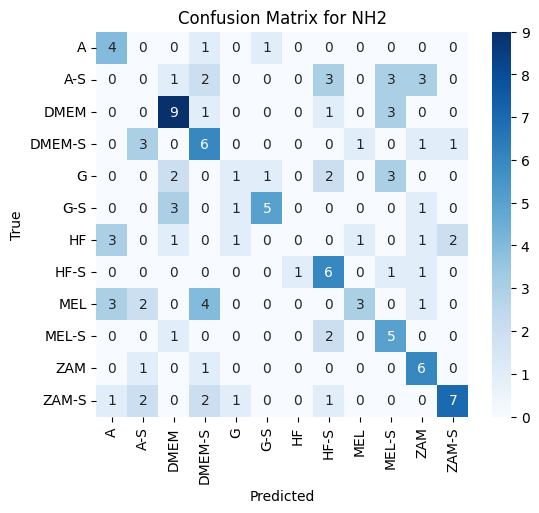

Best Parameters for COOH: {'kernel': 'rbf', 'gamma': np.float64(0.31622776601683794), 'C': np.float64(10.0)}
SVM Classification Report for COOH:
              precision    recall  f1-score   support

           0       0.30      0.50      0.38         6
           1       0.17      0.17      0.17        12
           2       0.00      0.00      0.00        14
           3       0.08      0.08      0.08        12
           4       0.36      0.44      0.40         9
           5       0.25      0.30      0.27        10
           6       0.71      0.56      0.62         9
           7       0.23      0.33      0.27         9
           8       0.20      0.08      0.11        13
           9       0.50      0.50      0.50         8
          10       0.22      0.50      0.31         8
          11       0.60      0.43      0.50        14

    accuracy                           0.29       124
   macro avg       0.30      0.32      0.30       124
weighted avg       0.29      0.29      0.28

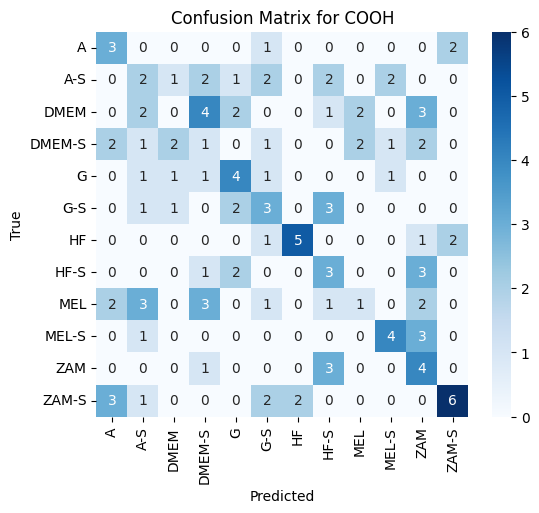

Best Parameters for COOH2: {'kernel': 'rbf', 'gamma': np.float64(0.31622776601683794), 'C': np.float64(10.0)}
SVM Classification Report for COOH2:
              precision    recall  f1-score   support

           0       0.25      0.67      0.36         6
           1       0.11      0.08      0.10        12
           2       0.33      0.07      0.12        14
           3       0.26      0.50      0.34        12
           4       0.00      0.00      0.00         9
           5       0.54      0.70      0.61        10
           6       0.40      0.22      0.29         9
           7       0.44      0.44      0.44         9
           8       0.50      0.54      0.52        13
           9       0.12      0.25      0.17         8
          10       0.12      0.12      0.12         8
          11       0.71      0.36      0.48        14

    accuracy                           0.32       124
   macro avg       0.32      0.33      0.30       124
weighted avg       0.34      0.32      0.

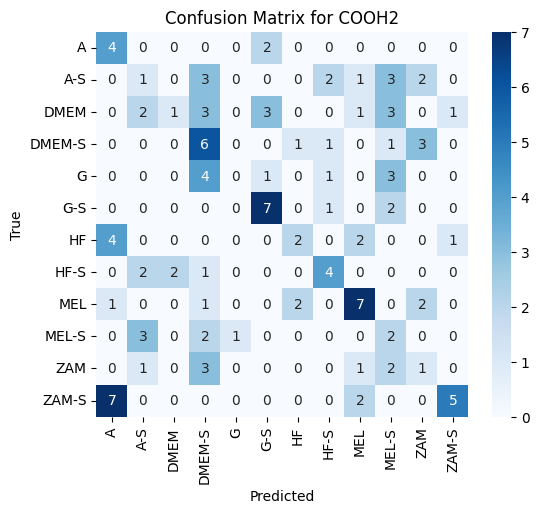

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV

def apply_pca_svm(df, condition, title):
    # Transpose data
    data = df.transpose().values

    # Ensure condition matches the number of samples
    min_samples = min(len(data), len(condition))
    data = data[:min_samples]
    condition = condition[:min_samples]

    # Perform PCA
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(data)

    # Encode labels
    le = LabelEncoder()
    labels = le.fit_transform(condition)

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(pca_result, labels, test_size=0.2, random_state=42)

    # Define hyperparameter search space
    param_dist = {
    'C': np.logspace(-1, 1, 5),  # Reduced to 5 values between 0.1 and 10
    'gamma': np.logspace(-2, 0, 5),  # Reduced to 5 values between 0.01 and 1
    'kernel': ['rbf', 'poly']  # Only RBF and Polynomial kernels
    }
    # Perform hyperparameter tuning with RandomizedSearchCV
    random_search = RandomizedSearchCV(SVC(), param_dist, n_iter=20, cv=5, scoring='accuracy', n_jobs=-1, random_state=42)
    random_search.fit(X_train, y_train)

    # Get the best model
    best_params = random_search.best_params_
    print(f"Best Parameters for {title}: {best_params}")

    # Train best SVM model
    svm = random_search.best_estimator_
    svm.fit(X_train, y_train)

    # Predict on test data
    y_pred = svm.predict(X_test)

    # Print accuracy and classification report
    print(f"SVM Classification Report for {title}:")
    print(classification_report(y_test, y_pred))
    print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

    # Plot confusion matrix
    conf_mat = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix for {title}')
    plt.show()

# Apply PCA and SVM to different datasets
apply_pca_svm(df_NH2, condition, 'NH2')
apply_pca_svm(df_COOH, condition, 'COOH')
apply_pca_svm(df_COOH2, condition, 'COOH2')

LDA applied for NH2
Best Parameters for NH2: {'kernel': 'rbf', 'gamma': np.float64(0.01), 'C': np.float64(3.1622776601683795)}
SVM Classification Report for NH2:
              precision    recall  f1-score   support

           0       0.71      0.83      0.77         6
           1       1.00      0.83      0.91        12
           2       0.92      0.79      0.85        14
           3       0.92      1.00      0.96        12
           4       0.70      0.78      0.74         9
           5       0.78      0.70      0.74        10
           6       0.53      0.89      0.67         9
           7       0.90      1.00      0.95         9
           8       0.93      1.00      0.96        13
           9       1.00      1.00      1.00         8
          10       1.00      1.00      1.00         8
          11       0.88      0.50      0.64        14

    accuracy                           0.85       124
   macro avg       0.86      0.86      0.85       124
weighted avg       0.87   

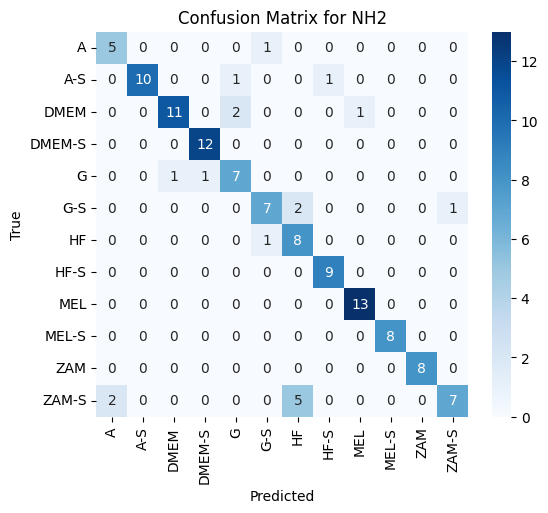

LDA applied for COOH
Best Parameters for COOH: {'kernel': 'rbf', 'gamma': np.float64(0.01), 'C': np.float64(3.1622776601683795)}
SVM Classification Report for COOH:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       0.91      0.83      0.87        12
           2       0.86      0.86      0.86        14
           3       0.50      0.58      0.54        12
           4       0.40      0.22      0.29         9
           5       0.80      0.80      0.80        10
           6       0.46      0.67      0.55         9
           7       0.90      1.00      0.95         9
           8       1.00      1.00      1.00        13
           9       0.55      0.75      0.63         8
          10       1.00      0.88      0.93         8
          11       0.90      0.64      0.75        14

    accuracy                           0.77       124
   macro avg       0.77      0.77      0.76       124
weighted avg       0.78

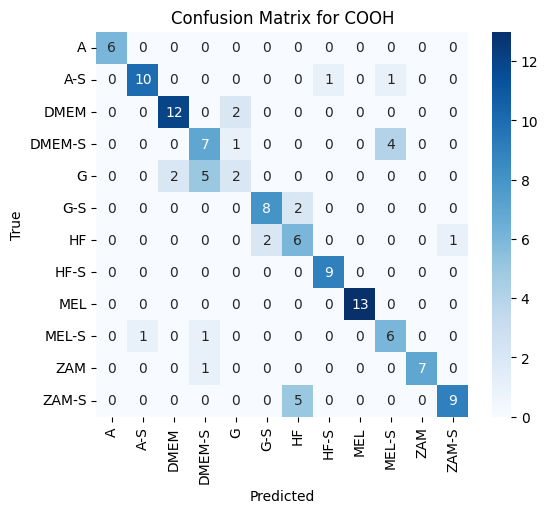

LDA applied for COOH2
Best Parameters for COOH2: {'kernel': 'rbf', 'gamma': np.float64(0.01), 'C': np.float64(3.1622776601683795)}
SVM Classification Report for COOH2:
              precision    recall  f1-score   support

           0       0.57      0.67      0.62         6
           1       0.83      0.83      0.83        12
           2       1.00      0.64      0.78        14
           3       0.73      0.92      0.81        12
           4       0.71      0.56      0.62         9
           5       0.73      0.80      0.76        10
           6       0.56      0.56      0.56         9
           7       0.80      0.89      0.84         9
           8       0.81      1.00      0.90        13
           9       0.86      0.75      0.80         8
          10       0.88      0.88      0.88         8
          11       0.85      0.79      0.81        14

    accuracy                           0.78       124
   macro avg       0.78      0.77      0.77       124
weighted avg       0

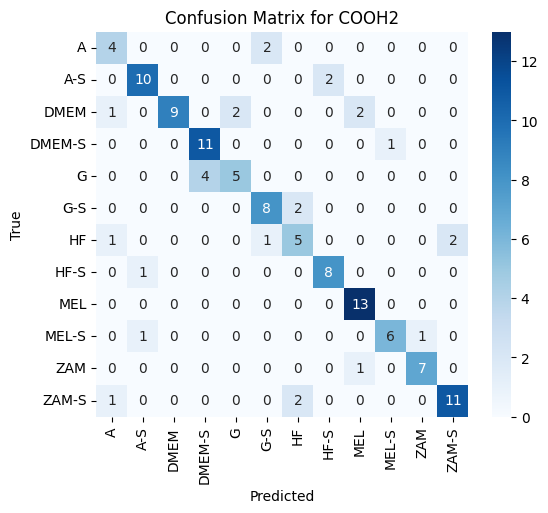

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV

def apply_lda_pca_svm(df, condition, title):
    # Transpose data
    data = df.transpose().values

    # Ensure condition matches the number of samples
    min_samples = min(len(data), len(condition))
    data = data[:min_samples]
    condition = condition[:min_samples]

    # Encode labels
    le = LabelEncoder()
    labels = le.fit_transform(condition)

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

    # Try LDA first
    try:
        lda = LDA(n_components=min(len(np.unique(y_train)) - 1, X_train.shape[1]))  # LDA components ≤ classes - 1
        X_train_transformed = lda.fit_transform(X_train, y_train)
        X_test_transformed = lda.transform(X_test)
        print(f"LDA applied for {title}")
    except Exception as e:
        print(f"LDA failed for {title}, falling back to PCA. Error: {e}")
        pca = PCA(n_components=2)
        X_train_transformed = pca.fit_transform(X_train)
        X_test_transformed = pca.transform(X_test)

    # Define reduced hyperparameter search space
    param_dist = {
        'C': np.logspace(-1, 1, 5),  # Reduced to 5 values between 0.1 and 10
        'gamma': np.logspace(-2, 0, 5),  # Reduced to 5 values between 0.01 and 1
        'kernel': ['rbf', 'poly']  # Only RBF and Polynomial kernels
    }

    # Perform hyperparameter tuning with RandomizedSearchCV
    random_search = RandomizedSearchCV(SVC(), param_dist, n_iter=10, cv=5, scoring='accuracy', n_jobs=-1, random_state=42)
    random_search.fit(X_train_transformed, y_train)

    # Get the best model
    best_params = random_search.best_params_
    print(f"Best Parameters for {title}: {best_params}")

    # Train best SVM model
    svm = random_search.best_estimator_
    svm.fit(X_train_transformed, y_train)

    # Predict on test data
    y_pred = svm.predict(X_test_transformed)

    # Print accuracy and classification report
    print(f"SVM Classification Report for {title}:")
    print(classification_report(y_test, y_pred))
    print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

    # Plot confusion matrix
    conf_mat = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix for {title}')
    plt.show()

# Apply LDA (or PCA fallback) and SVM to different datasets
apply_lda_pca_svm(df_NH2, condition, 'NH2')
apply_lda_pca_svm(df_COOH, condition, 'COOH')
apply_lda_pca_svm(df_COOH2, condition, 'COOH2')


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pandas as pd # Import pandas
import glob # Import glob
import os # Import os

# Assuming 'data' dictionary and 'normalize' function are defined in previous cells
# Re-run the cells that define 'data' and 'normalize' if necessary.

# Recreate df_NH2 and its corresponding condition list
condition_NH2 = []
df_NH2 = pd.DataFrame()
l = 0
for i in data:
    if 'NH2' in data[i]:
        for k in data[i]['NH2']:
            condition_NH2.append(i)
            df_NH2[l] = k
            l = l + 1

# Recreate df_COOH and its corresponding condition list
condition_COOH = []
df_COOH = pd.DataFrame()
l = 0
for i in data:
    if 'COOH' in data[i]:
        for k in data[i]['COOH']:
            condition_COOH.append(i)
            df_COOH[l] = k
            l = l + 1

# Recreate df_COOH2 and its corresponding condition list
condition_COOH2 = []
df_COOH2 = pd.DataFrame()
l = 0
for i in data:
    if '(COOH)2' in data[i]:
        for k in data[i]['(COOH)2']:
            condition_COOH2.append(i)
            df_COOH2[l] = k
            l = l + 1


def process_and_train_cnn_1d(df, condition, title):
    # Convert DataFrame to NumPy array and transpose so samples are rows
    data = df.transpose().values

    # Ensure condition matches the number of samples after transposing
    # The number of samples is now the number of rows in the transposed data
    num_samples = data.shape[0]
    # No longer need to trim condition here as it's built to match the df

    # Encode labels
    le = LabelEncoder()
    labels = le.fit_transform(condition)
    labels = to_categorical(labels)  # Convert labels to one-hot encoding

    # Reshape data for 1D CNN: (samples, time_steps, channels)
    # After transpose, num_features is the number of columns in data
    _, num_features = data.shape
    data = data.reshape((num_samples, num_features, 1))  # 1 channel (similar to grayscale)

    # Split into training and testing sets
    # Now data and labels should have the same number of samples (rows)
    X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

    # Define 1D CNN model
    model = Sequential([
        Conv1D(128, kernel_size=8, activation='relu', input_shape=(num_features, 1)),
        MaxPooling1D(pool_size=4, strides=2),
        Conv1D(64, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=4, strides=2),
        Conv1D(32, kernel_size=2, activation='relu'),
        MaxPooling1D(pool_size=2, strides=2),
        Flatten(),
        Dropout(0.5),
        Dense(128, activation='relu'),
        Dense(labels.shape[1], activation='softmax')  # Output layer for classification
    ])

    # Compile model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # Train model
    history = model.fit(X_train, y_train, batch_size=32, epochs=200, validation_data=(X_test, y_test))

    # Evaluate model
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    print(f"Test Accuracy for {title}: {test_acc:.4f}")

    return model

# Apply 1D CNN to different datasets using the specific condition lists
model_NH2 = process_and_train_cnn_1d(df_NH2, condition_NH2, 'NH2')
model_COOH = process_and_train_cnn_1d(df_COOH, condition_COOH, 'COOH')
model_COOH2 = process_and_train_cnn_1d(df_COOH2, condition_COOH2, 'COOH2')

<ipython-input-38-49e60172be67>:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_NH2[l] = k
<ipython-input-38-49e60172be67>:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_NH2[l] = k
<ipython-input-38-49e60172be67>:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_NH2[l] = k
<ipython-inpu

Epoch 1/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 271ms/step - accuracy: 0.1008 - loss: 2.4781 - val_accuracy: 0.0866 - val_loss: 2.5332
Epoch 2/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2949 - loss: 2.2475 - val_accuracy: 0.3150 - val_loss: 1.9732
Epoch 3/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.4660 - loss: 1.6885 - val_accuracy: 0.5354 - val_loss: 1.3708
Epoch 4/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.6294 - loss: 1.1479 - val_accuracy: 0.6614 - val_loss: 1.0051
Epoch 5/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7124 - loss: 0.8713 - val_accuracy: 0.6772 - val_loss: 0.9000
Epoch 6/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.7718 - loss: 0.6369 - val_accuracy: 0.8110 - val_loss: 0.5206
Epoch 7/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.8816 - loss: 0.4094 - val_accuracy: 0.9291 - val_loss: 0.2744
Epoch 8/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8974 - loss: 0.2626 - val_accuracy: 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 208ms/step - accuracy: 0.0957 - loss: 2.4872 - val_accuracy: 0.0630 - val_loss: 2.4753
Epoch 2/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.1317 - loss: 2.4205 - val_accuracy: 0.1654 - val_loss: 2.2420
Epoch 3/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.2677 - loss: 2.0260 - val_accuracy: 0.4094 - val_loss: 1.7437
Epoch 4/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.4571 - loss: 1.6054 - val_accuracy: 0.4409 - val_loss: 1.5419
Epoch 5/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.5380 - loss: 1.3197 - val_accuracy: 0.6614 - val_loss: 1.0068
Epoch 6/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6716 - loss: 0.9415 - val_accuracy: 0.8583 - val_loss: 0.5910
Epoch 7/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8288 - loss: 0.5876 - val_accuracy: 0.8898 - val_loss: 0.4064
Epoch 8/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8676 - loss: 0.4055 - val_accuracy: 0.8976 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 287ms/step - accuracy: 0.1216 - loss: 2.4896 - val_accuracy: 0.1508 - val_loss: 2.4590
Epoch 2/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2306 - loss: 2.4080 - val_accuracy: 0.3254 - val_loss: 2.1821
Epoch 3/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.3894 - loss: 1.9608 - val_accuracy: 0.5397 - val_loss: 1.5227
Epoch 4/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.5313 - loss: 1.3674 - val_accuracy: 0.5873 - val_loss: 1.2455
Epoch 5/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.6229 - loss: 1.1175 - val_accuracy: 0.6667 - val_loss: 1.0400
Epoch 6/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7102 - loss: 0.8546 - val_accuracy: 0.7778 - val_loss: 0.7393
Epoch 7/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7944 - loss: 0.6331 - val_accuracy: 0.8651 - val_loss: 0.5202
Epoch 8/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8567 - loss: 0.4620 - val_accuracy: 0.8651 - val_

In [ ]:
print(f"Feature shape: {df_NH2.shape}")  # Should be (N, features)
print(f"Condition length: {len(condition)}")  # Should be N


Feature shape: (2090, 632)
Condition length: 618


Training and plotting for NH2 dataset:


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test Accuracy for NH2: 1.0000


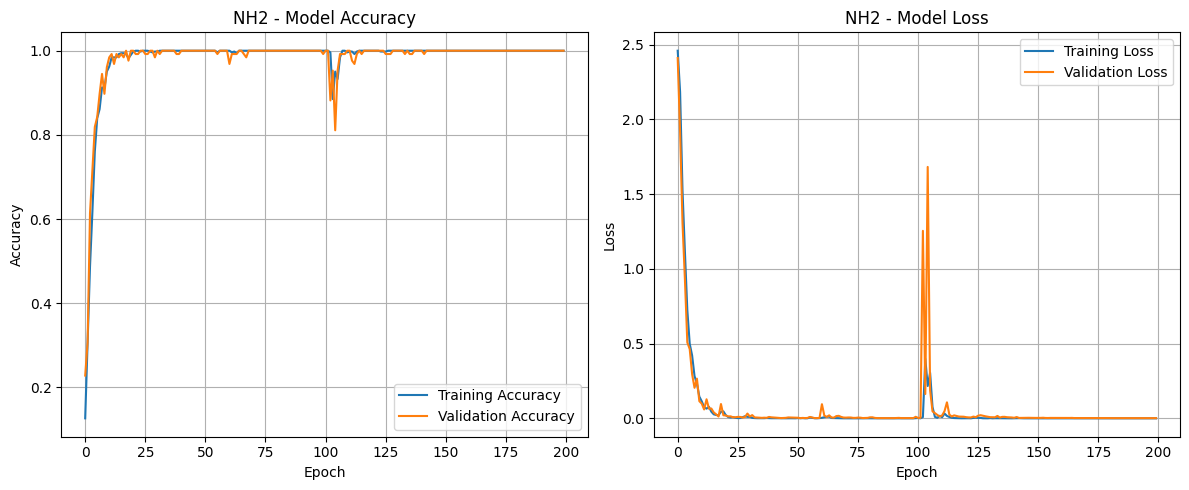


Training and plotting for COOH dataset:


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test Accuracy for COOH: 1.0000


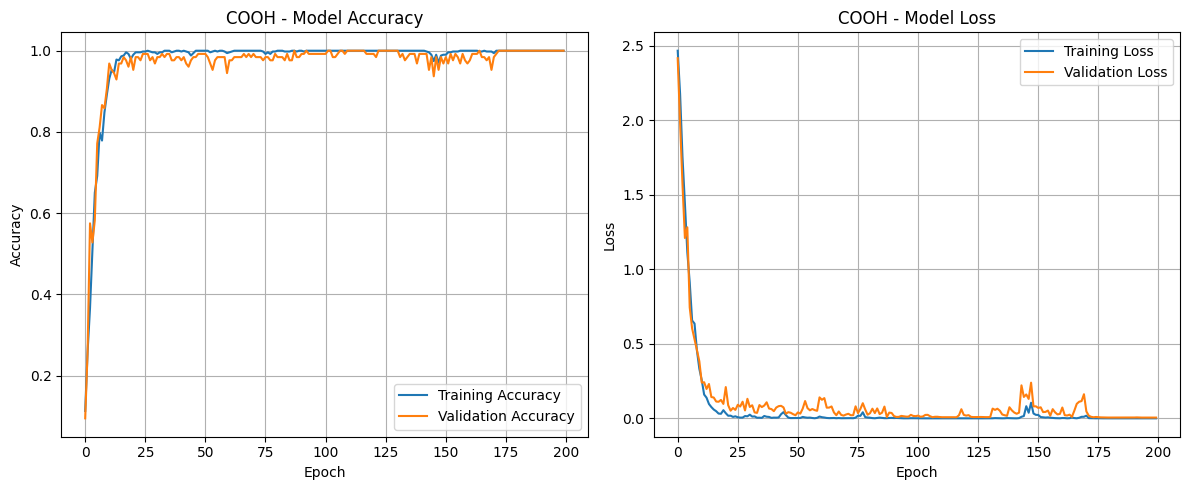


Training and plotting for COOH2 dataset:


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test Accuracy for COOH2: 0.9921


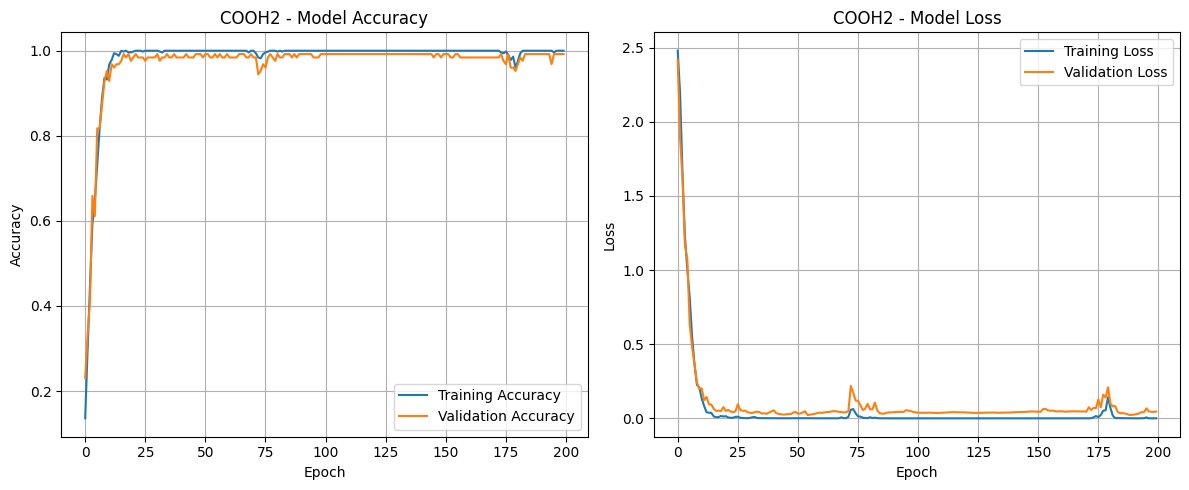

In [ ]:
# prompt: plot the results from above training

# The training history is returned by the `model.fit` method.
# We can access the accuracy and loss from the history object.

def plot_training_history(history, title):
    """Plots the training and validation accuracy and loss over epochs."""
    plt.figure(figsize=(12, 5))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{title} - Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{title} - Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Re-run the training function and capture the history object
def process_and_train_cnn_1d_with_history(df, condition, title):
    # Convert DataFrame to NumPy array and transpose so samples are rows
    data = df.transpose().values

    # Ensure condition matches the number of samples after transposing
    num_samples = data.shape[0]

    # Encode labels
    le = LabelEncoder()
    labels = le.fit_transform(condition)
    # Check if there are enough samples for splitting and one-hot encoding
    if num_samples == 0 or len(np.unique(labels)) < 2:
        print(f"Insufficient data or classes for {title}. Skipping training.")
        return None

    labels = to_categorical(labels)  # Convert labels to one-hot encoding

    # Reshape data for 1D CNN: (samples, time_steps, channels)
    _, num_features = data.shape
    data = data.reshape((num_samples, num_features, 1))  # 1 channel (similar to grayscale)

    # Split into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

    # Define 1D CNN model
    model = Sequential([
        Conv1D(128, kernel_size=8, activation='relu', input_shape=(num_features, 1)),
        MaxPooling1D(pool_size=4, strides=2),
        Conv1D(64, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=4, strides=2),
        Conv1D(32, kernel_size=2, activation='relu'),
        MaxPooling1D(pool_size=2, strides=2),
        Flatten(),
        Dropout(0.5),
        Dense(128, activation='relu'),
        Dense(labels.shape[1], activation='softmax')  # Output layer for classification
    ])

    # Compile model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # Train model and capture history
    history = model.fit(X_train, y_train, batch_size=32, epochs=200, validation_data=(X_test, y_test), verbose=0) # Set verbose to 0 to reduce output during training

    # Evaluate model
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    print(f"Test Accuracy for {title}: {test_acc:.4f}")

    return history

from tensorflow.keras.utils import to_categorical
import tensorflow as tf

# Assuming df_NH2, df_COOH, df_COOH2 and their corresponding condition lists
# condition_NH2, condition_COOH, condition_COOH2 are already defined from the
# preceding code cells.

# Train and plot history for each dataset
print("Training and plotting for NH2 dataset:")
history_NH2 = process_and_train_cnn_1d_with_history(df_NH2, condition_NH2, 'NH2')
if history_NH2:
    plot_training_history(history_NH2, 'NH2')

print("\nTraining and plotting for COOH dataset:")
history_COOH = process_and_train_cnn_1d_with_history(df_COOH, condition_COOH, 'COOH')
if history_COOH:
    plot_training_history(history_COOH, 'COOH')

print("\nTraining and plotting for COOH2 dataset:")
history_COOH2 = process_and_train_cnn_1d_with_history(df_COOH2, condition_COOH2, 'COOH2')
if history_COOH2:
    plot_training_history(history_COOH2, 'COOH2')
